In [1]:
import numpy as np
import matplotlib.pyplot as plt
import fenics as fe

import sys
sys.path.insert(0, "../src")

from tqdm import tqdm

from swe import ShallowOne, ShallowOneLinear

control = dict(nx=500, dt=2., theta=0.6, simulation="tidal_flow")

[ 2000.          3142.85714286  4285.71428571  5428.57142857
  6571.42857143  7714.28571429  8857.14285714 10000.        ]
[1.00000000e+00 3.72759372e+00 1.38949549e+01 5.17947468e+01
 1.93069773e+02 7.19685673e+02 2.68269580e+03 1.00000000e+04]
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.


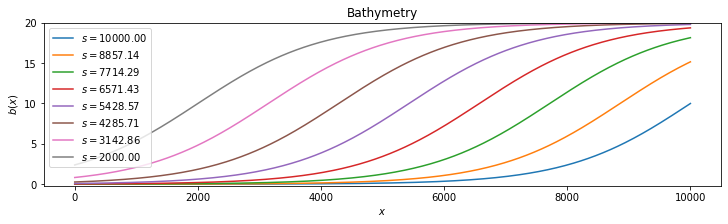

In [2]:
# set up bump/dissipation args
shore_starts = np.linspace(2000., 10_000., num=8)
nus = np.logspace(0., 4., num=8)
print(shore_starts)
print(nus)

shore_model_args = [
    (shore_start, 1., False) for shore_start in shore_starts]
shore_linear_model_args = [
    (shore_start, 1., True) for shore_start in shore_starts]
damped_model_args = [(2000., nu, False) for nu in nus]

# now plot the different bathymetries
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10, 3))
for s in shore_starts[::-1]:
    swe = ShallowOne(control=control, 
                     params=dict(nu=1.,
                                 shore_start=s, shore_height=5.,
                                 bump_height=0., bump_centre=1000., bump_width=400))
    fe.plot(30 - swe.H, label=fr"$s = {s:.2f}$")
    
ax.set_ylim(-0.2, 20)
ax.set_title("Bathymetry")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$b(x)$")
ax.legend()
plt.show()

In [3]:
fe.set_log_level(50)

def run_model(shore_start, nu, linear):
    if linear:
        swe = ShallowOneLinear(control=control,
                               params=dict(nu=nu,
                                           shore_start=shore_start, shore_height=10.,
                                           bump_height=0., bump_centre=1000., bump_width=400))
    else:
        swe = ShallowOne(control=control, 
                         params=dict(nu=nu,
                                     shore_start=shore_start, shore_height=10.,
                                     bump_height=0., bump_centre=1000., bump_width=400))
        
    t_final = 60 * 60 * 6.
    nt = int((t_final) / swe.dt)

    i_save = 0
    nt_skip = 5  # store every 10 s
    nt_save = len([i for i in range(nt) if i % nt_skip == 0])

    t_out = np.zeros((nt_save, ))
    u_out = np.zeros((nt_save, len(swe.mesh.coordinates())))
    h_out = np.zeros((nt_save, len(swe.mesh.coordinates())))

    t = 0.
    
    for i in tqdm(range(nt)):
        t += swe.dt
        try:
            swe.solve(t)
        except RuntimeError:
            print(f"Failed at time {t:.2e}, "
                  + f"returning all objects for s = {shore_start:.2f}, nu = {nu:.2f}")
            break

        if i % nt_skip == 0:
            t_out[i_save] = t
            u, h = swe.du.split()
            u_out[i_save, :] = u.compute_vertex_values()
            h_out[i_save, :] = h.compute_vertex_values()

            i_save += 1
    
    return [t_out, u_out, h_out]

In [4]:
ref_model = run_model(2000., 1., False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10800/10800 [00:55<00:00, 194.07it/s]


In [5]:
from multiprocessing import Pool

p = Pool(16)
out_shore = p.starmap(run_model, shore_model_args)
out_linear_shore = p.starmap(run_model, shore_linear_model_args)
out_damped = p.starmap(run_model, damped_model_args)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10800/10800 [00:56<00:00, 190.09it/s]


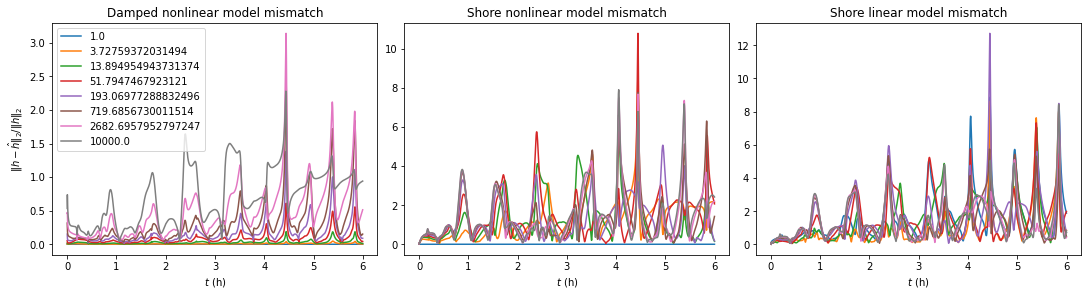

In [6]:
norm = np.linalg.norm

fig, axs = plt.subplots(1, 3, figsize=(15, 4), 
                        constrained_layout=True)

for model in out_damped:
    t_out = model[0]
    axs[0].plot(t_out / 3600,
                norm(ref_model[2] - model[2], axis=1) / norm(ref_model[2], axis=1))
axs[0].set_ylabel(r"$\Vert h - \hat{h} \Vert_2 / \Vert h \Vert_2$")
axs[0].set_title("Damped nonlinear model mismatch")
axs[0].legend(nus)

for model in out_shore:
    t_out = model[0]
    axs[1].plot(t_out / 3600, 
                norm(ref_model[2] - model[2], axis=1) / norm(ref_model[2], axis=1))
axs[1].set_title("Shore nonlinear model mismatch")

for model in out_linear_shore:
    t_out = model[0]
    axs[2].plot(t_out/ 3600, 
                norm(ref_model[2] - model[2], axis=1) / norm(ref_model[2], axis=1))
axs[2].set_title("Shore linear model mismatch")
for ax in axs:
    ax.set_xlabel(r"$t$ (h)")
plt.show()